In [5]:
!pip install gdown

In [28]:
import gdown
import zipfile
import os
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt

In [7]:
class ImageProcessor:
    def __init__(self, file_id, dest_dir, unannotated_images_dir):
        self.file_id = file_id
        self.url = f'https://drive.google.com/uc?id={file_id}'
        self.output = 'images.zip'
        self.dest_dir = dest_dir
        self.dest_dir_train = dest_dir+"train"
        self.dest_dir_test = dest_dir+"test"
        self.unannotated_images_dir = unannotated_images_dir
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.download_and_extract_images()

    def download_and_extract_images(self):
        print(f"Downloading images from {self.url}...")
        gdown.download(self.url, self.output, quiet=False)
        print("Extracting images...")
        with zipfile.ZipFile(self.output, 'r') as zip_ref:
            zip_ref.extractall(self.unannotated_images_dir)
        print(f"Images extracted to {self.unannotated_images_dir}")

    def get_batch_size(self, batch_size):
        return batch_size
    
    def get_dest_dir_train(self):
        return self.dest_dir_train
    
    def get_dest_dir_test(self):
        return self.dest_dir_test
    
    def get_dest_dir_unannotated_images(self):
        return self.unannotated_images_dir+"images_all/"

    def get_epochs(self, epochs):
        return epochs

    def get_device(self):
        return self.device


In [8]:
class DataTransforms:
    def __init__(self, resize_crop):
        self.resize_crop = resize_crop
        self.transforms = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(self.resize_crop),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'test': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(self.resize_crop),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
        }

    def get_transforms(self, phase):
        return self.transforms.get(phase, None)

In [9]:
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.image_files[idx]

In [10]:
class UnannotatedDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.image_files[idx]

    def get_subset(self, subset_size):
        indices = list(range(len(self.image_files)))
        subset_indices = random.sample(indices, subset_size)
        return subset_indices

In [11]:
class PseudoLabeledDataset(Dataset):
    def __init__(self, original_dataset, pseudo_dataset, pseudo_labels, transform=None):
        self.original_dataset = original_dataset
        self.pseudo_dataset = pseudo_dataset
        self.pseudo_labels = pseudo_labels
        self.transform = transform

    def __len__(self):
        return len(self.original_dataset) + len(self.pseudo_dataset)

    def __getitem__(self, idx):
        if idx < len(self.original_dataset):
            
            return self.original_dataset[idx]
        else:
            pseudo_idx = idx - len(self.original_dataset)
            image, _ = self.pseudo_dataset[pseudo_idx]
            label = self.pseudo_labels[pseudo_idx][1]
            return image, label

In [20]:
loss_per_epoch = []
acuuracy_per_epoch = []


def train_model(model, criterion, optimizer, num_epochs, data_loader, dataset_size):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_size
        epoch_acc = running_corrects.double() / dataset_size
        acuuracy_per_epoch.append(epoch_acc.item())
        loss_per_epoch.append(epoch_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')

    return model

In [13]:
class ModelPredictor:
    def __init__(self, model, loader, device):
        self.model = model
        self.loader = loader
        self.device = device
        self.model.to(self.device)
        self.model.eval()

    def predict(self):
        predictions = []
        with torch.no_grad():
            for inputs, image_names in self.loader:
                inputs = inputs.to(self.device)
                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)
                for img_name, pred in zip(image_names, preds):
                    predictions.append((img_name, int(pred.item())))
        return predictions

    def save_predictions_to_csv(self, predictions, filename='submission.csv'):
        predictions_df = pd.DataFrame(predictions, columns=['image', 'class'])
        predictions_df.to_csv(filename, index=False)
        print(f'Predictions saved to {filename}')

In [14]:
# setting up project basic links and device
# parameters for image_processor class(file_id, dest_dir, unannotated_images_dir,batch_size,epochs)
image_processor = ImageProcessor('1jEq_s88uoo6do1U4Spsd1fuwxv_XI05q', '/kaggle/input/ai-unict-2024-challenge-1/', '/kaggle/working/images/')

device = image_processor.get_device()
train_dir = image_processor.get_dest_dir_train()
test_dir = image_processor.get_dest_dir_test()
unannotated_images_dir = image_processor.get_dest_dir_unannotated_images()

print(f"Device: {device}, Train Dir: {train_dir}, Test Dir: {test_dir}, Unannotated Images: {unannotated_images_dir}")

Downloading...
From (original): https://drive.google.com/uc?id=1jEq_s88uoo6do1U4Spsd1fuwxv_XI05q
From (redirected): https://drive.google.com/uc?id=1jEq_s88uoo6do1U4Spsd1fuwxv_XI05q&confirm=t&uuid=822d65a4-1528-4b8f-b7a1-dea9a5a5b3a8
To: /kaggle/working/images.zip
100%|██████████| 138M/138M [00:01<00:00, 74.2MB/s] 


Extracting images...
Images extracted to /kaggle/working/images/
Device: cuda, Train Dir: /kaggle/input/ai-unict-2024-challenge-1/train, Test Dir: /kaggle/input/ai-unict-2024-challenge-1/test, Unannotated Images: /kaggle/working/images/images_all/


In [22]:
# setting epochs before using any variable
epochs = image_processor.get_epochs(150)

#defining batch size before using train loader
batch_size = image_processor.get_batch_size(64)

#sample image size if we are using unlabel dataset
unannotated_dataset_image_sample_size = 150

# crop size depending on which model you may selecte
resize_crop = 224

# defining model

#resnet18
"""
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 15)
"""

#resnet50
"""
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 15)
"""

#vgg16
"""
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(4096, 15)
"""

#densenet121
model = models.densenet121(pretrained=True)
num_ftrs = model.classifier.in_features
model.fc = nn.Linear(num_ftrs, 15)

model = model.to(device)

# selection of optimizer SGD
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# selection of optimizer ADAM
"""
optimizer = optim.Adam(model.parameters(), lr=0.001)
"""

# for the loss
criterion = nn.CrossEntropyLoss()

In [23]:
#basic data transformation
data_transforms = DataTransforms(resize_crop)
train_transforms = data_transforms.get_transforms('train')
test_transforms = data_transforms.get_transforms('test')

# preparing train dataset from the specified directory with all transformation
train_dataset = datasets.ImageFolder(os.path.join(train_dir), train_transforms)

# preparing train loader for batching and shuffling the training dataset during training
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# preparing test dataset from the specified directory with all transformation
test_dataset = TestDataset(test_dir, test_transforms)

# preparing test loader for batching without shuffling to preserve order
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Train the model
print('Model start training')
model = train_model(model, criterion, optimizer, epochs, train_loader , len(train_dataset))

Model start training
Epoch 1/150, Loss: 9.0933, Acc: 0.0000
Epoch 2/150, Loss: 8.2736, Acc: 0.0133
Epoch 3/150, Loss: 6.5655, Acc: 0.0200
Epoch 4/150, Loss: 5.1945, Acc: 0.1800
Epoch 5/150, Loss: 3.7386, Acc: 0.3733
Epoch 6/150, Loss: 2.5100, Acc: 0.5667
Epoch 7/150, Loss: 1.6544, Acc: 0.7000
Epoch 8/150, Loss: 1.0043, Acc: 0.8467
Epoch 9/150, Loss: 0.8684, Acc: 0.8200
Epoch 10/150, Loss: 0.6760, Acc: 0.8400
Epoch 11/150, Loss: 0.7475, Acc: 0.8267
Epoch 12/150, Loss: 0.3328, Acc: 0.9133
Epoch 13/150, Loss: 0.3665, Acc: 0.9133
Epoch 14/150, Loss: 0.3043, Acc: 0.9067
Epoch 15/150, Loss: 0.2385, Acc: 0.9400
Epoch 16/150, Loss: 0.2524, Acc: 0.9533
Epoch 17/150, Loss: 0.3452, Acc: 0.8933
Epoch 18/150, Loss: 0.3261, Acc: 0.9400
Epoch 19/150, Loss: 0.2645, Acc: 0.9400
Epoch 20/150, Loss: 0.1480, Acc: 0.9667
Epoch 21/150, Loss: 0.1669, Acc: 0.9600
Epoch 22/150, Loss: 0.2039, Acc: 0.9400
Epoch 23/150, Loss: 0.2068, Acc: 0.9667
Epoch 24/150, Loss: 0.1809, Acc: 0.9400
Epoch 25/150, Loss: 0.1226, 

In [24]:
#we can skip this step if we are not using unlabel dataset

#loading unannotated dataset
unannotated_dataset = UnannotatedDataset(unannotated_images_dir, train_transforms)

subset_indices = unannotated_dataset.get_subset(unannotated_dataset_image_sample_size)

unannotated_subset = torch.utils.data.Subset(unannotated_dataset, subset_indices)
unannotated_loader = DataLoader(unannotated_subset, batch_size=batch_size, shuffle=False, num_workers=4)

unannotated_img_predictor = ModelPredictor(model, unannotated_loader, device)
unannotated_img_predictor = unannotated_img_predictor.predict()

combined_dataset = PseudoLabeledDataset(train_dataset, unannotated_subset, unannotated_img_predictor, train_transforms)
combined_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Re-train the model with combined dataset
print('Model start retraining on Combine Data')
# setting epochs before using any variable
epochs = image_processor.get_epochs(500)
model = train_model(model, criterion, optimizer, epochs, combined_loader, len(combined_dataset))

Model start retraining on Combine Data
Epoch 1/500, Loss: 1.3723, Acc: 0.6800
Epoch 2/500, Loss: 0.9081, Acc: 0.7700
Epoch 3/500, Loss: 0.8179, Acc: 0.7967
Epoch 4/500, Loss: 0.6495, Acc: 0.8167
Epoch 5/500, Loss: 0.5600, Acc: 0.8433
Epoch 6/500, Loss: 0.5209, Acc: 0.8500
Epoch 7/500, Loss: 0.3981, Acc: 0.8700
Epoch 8/500, Loss: 0.3521, Acc: 0.8667
Epoch 9/500, Loss: 0.3385, Acc: 0.9067
Epoch 10/500, Loss: 0.3369, Acc: 0.8933
Epoch 11/500, Loss: 0.3187, Acc: 0.9000
Epoch 12/500, Loss: 0.3028, Acc: 0.9067
Epoch 13/500, Loss: 0.2499, Acc: 0.9267
Epoch 14/500, Loss: 0.2031, Acc: 0.9333
Epoch 15/500, Loss: 0.2411, Acc: 0.9367
Epoch 16/500, Loss: 0.1929, Acc: 0.9467
Epoch 17/500, Loss: 0.2312, Acc: 0.9200
Epoch 18/500, Loss: 0.2090, Acc: 0.9467
Epoch 19/500, Loss: 0.1728, Acc: 0.9433
Epoch 20/500, Loss: 0.2339, Acc: 0.9200
Epoch 21/500, Loss: 0.2287, Acc: 0.9267
Epoch 22/500, Loss: 0.2502, Acc: 0.9133
Epoch 23/500, Loss: 0.1764, Acc: 0.9467
Epoch 24/500, Loss: 0.1583, Acc: 0.9633
Epoch 25/5

In [37]:
# Evaluate the model on the test set
print('Model Prediction')
predictor = ModelPredictor(model, test_loader, device)
predictions = predictor.predict()
predictor.save_predictions_to_csv(predictions)

Model Prediction
Predictions saved to submission.csv


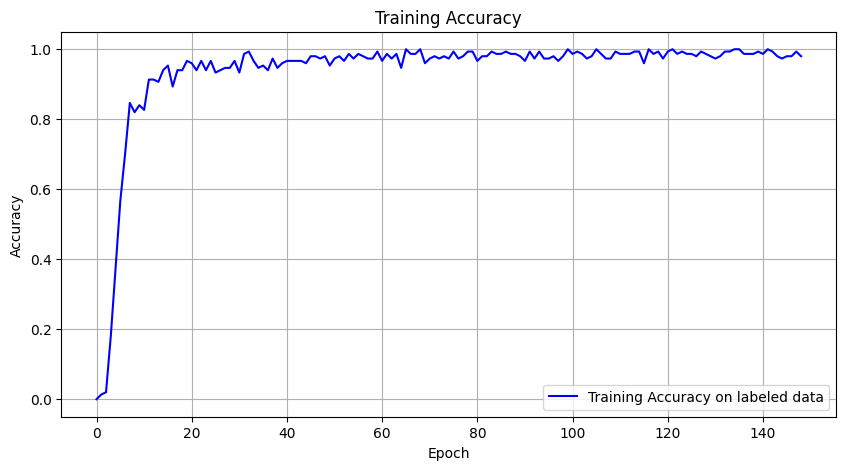

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(acuuracy_per_epoch[0:149], label='Training Accuracy on labeled data', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.grid(True)
plt.show()

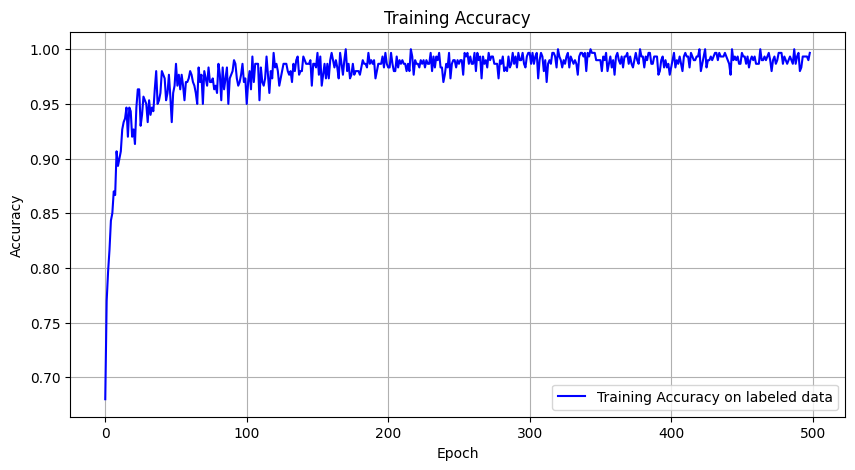

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(acuuracy_per_epoch[150:649], label='Training Accuracy on unlabeled data', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.grid(True)
plt.show()

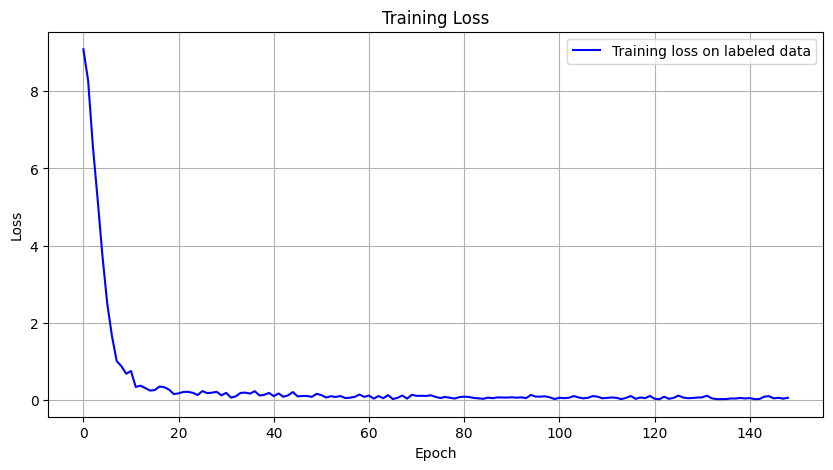

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(loss_per_epoch[0:149], label='Training loss on labeled data', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

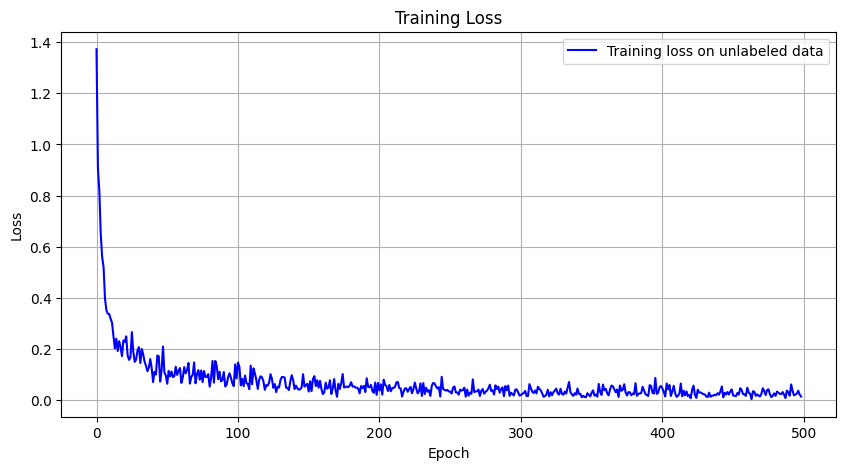

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(loss_per_epoch[150:649], label='Training loss on unlabeled data', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.show()